# Ensure SerpAPI is imported

In [ ]:
!pip install google-search-results
!pip install fredapi

# Graphics Cards Price Comparison
What are the prices of some of the most popular graphics cards?

Taking GPU price snapshots via SerpAPI...
Fetching FRED series WPU5841 since 2020-01-01...


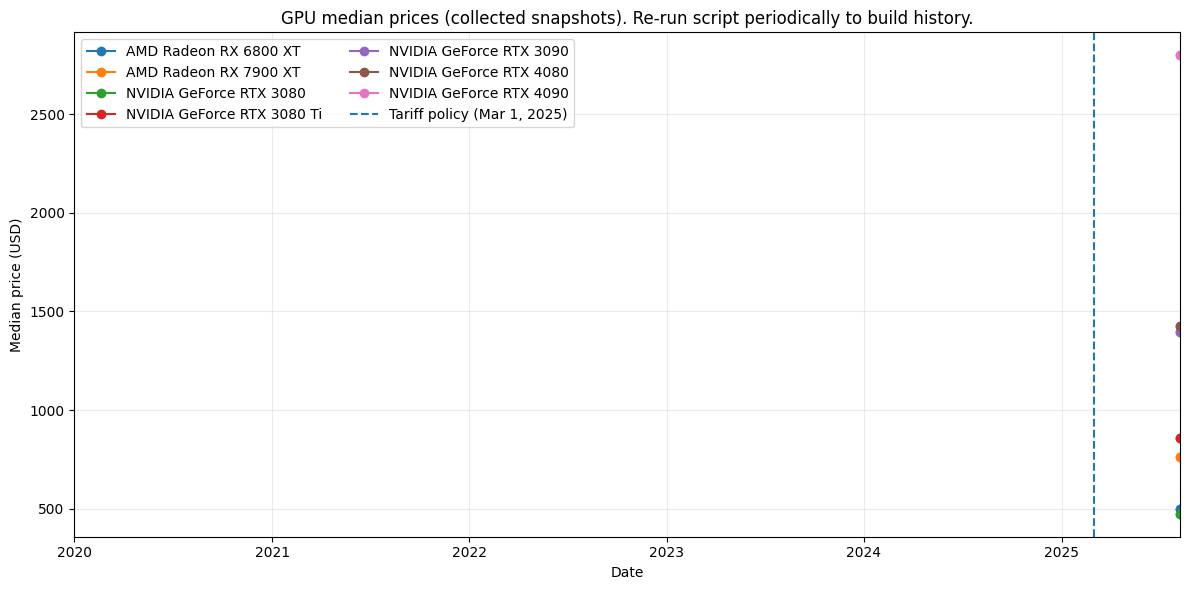

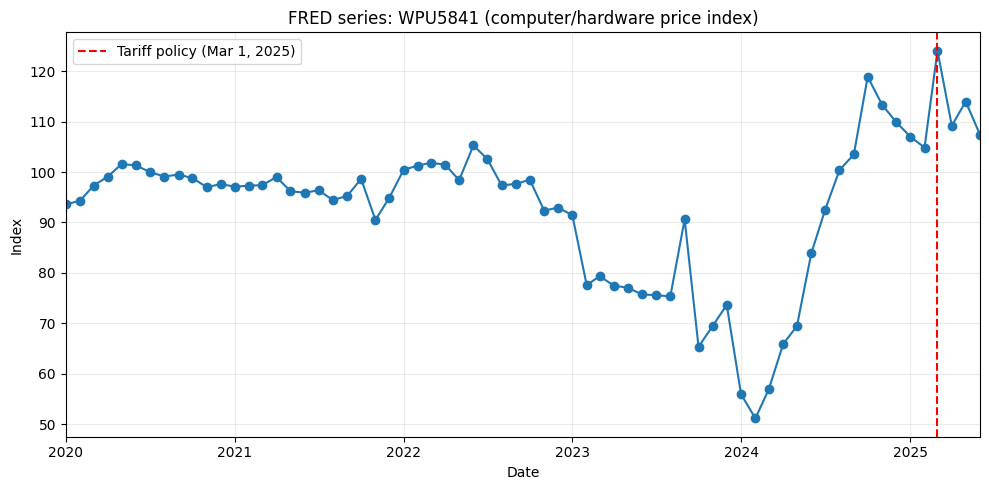

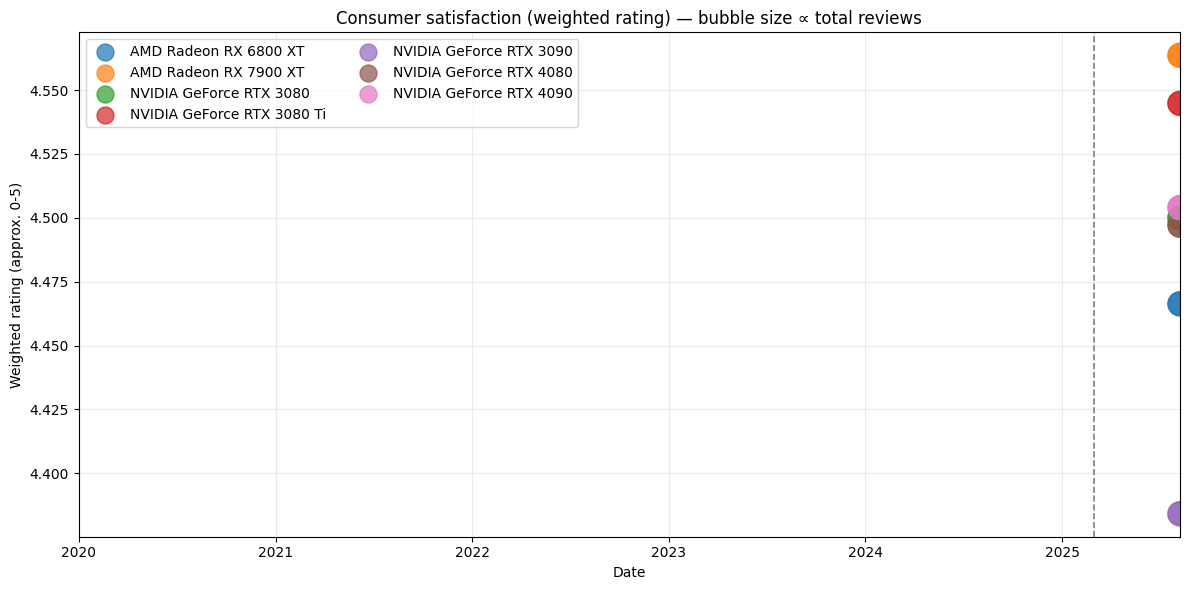

Done. GPU history saved to: gpu_price_history.csv


In [ ]:
"""
gpu_price_trends.py

Requirements:
  pip install serpapi fredapi pandas matplotlib requests

Usage:
  - Set SERPAPI_API_KEY and FRED_API_KEY (or pass keys into the script).
  - Run: python gpu_price_trends.py
  - Re-run periodically (cron) to build GPU historical CSV (gpu_price_history.csv).
"""

import os
import time
import datetime as dt
import math
import pandas as pd
import matplotlib.pyplot as plt
from serpapi import GoogleSearch
from fredapi import Fred
import requests

# -------------------------
# CONFIG
# -------------------------
SERPAPI_API_KEY = "b484735aff7d4281635c4e98dabddeb9e8fff811b87264da95c846d48386e966" # or put your key string here
FRED_API_KEY = "e3a98eb469aa0274d69879357df6d096" # or put your key string here

# GPUs to track (tweak model names to be precise for shopping queries)
GPU_MODELS = [
    "NVIDIA GeForce RTX 3080",
    "NVIDIA GeForce RTX 3080 Ti",
    "NVIDIA GeForce RTX 3090",
    "NVIDIA GeForce RTX 4080",
    "NVIDIA GeForce RTX 4090",
    "AMD Radeon RX 6800 XT",
    "AMD Radeon RX 7900 XT",
]

# File to accumulate GPU price snapshots (creates if missing)
HISTORY_CSV = "gpu_price_history.csv"

# FRED series to use as macro price index for "computers/hardware"
# You can change the series ID to other FRED series; example here uses
# 'WPU5841' (Producer Price Index by Commodity: Computer Hardware, Software, and Supplies Retailing)
FRED_SERIES_ID = "WPU5841"

# Tariff policy event date to mark on charts
TARIFF_DATE = dt.datetime(2025, 3, 1)  # March 1, 2025

# Date to consider "start of COVID period" (for plot ranges)
COVID_START = dt.datetime(2020, 1, 1)

# -------------------------
# Helper: SerpAPI shopping search for a specific GPU model
# Returns a list of product dicts with price, old_price, rating, reviews, source
# -------------------------
def serpapi_get_shopping_for_model(model_name, serpapi_key):
    params = {
        "engine": "google_shopping",
        "q": model_name,
        "hl": "en",
        "gl": "us",
        "api_key": serpapi_key,
    }
    search = GoogleSearch(params)
    result = search.get_dict()

    shopping_results = result.get("shopping_results", [])
    if not isinstance(shopping_results, list):
        shopping_results = []

    parsed = []
    for item in shopping_results:
        # SerpAPI sometimes returns extracted_price, sometimes price string
        def parse_price(p):
            if not p:
                return None
            s = str(p).replace("$", "").replace(",", "").strip()
            try:
                return float(s)
            except:
                import re
                m = re.search(r"(\d[\d,]*\.?\d*)", s)
                return float(m.group(1).replace(",", "")) if m else None

        price = parse_price(item.get("extracted_price") or item.get("price"))
        old_price = parse_price(item.get("extracted_old_price") or item.get("old_price"))

        rating = item.get("rating")
        reviews = item.get("reviews")
        try:
            rating = float(rating) if rating is not None else None
        except:
            rating = None
        try:
            reviews = int(str(reviews).replace(",", "")) if reviews is not None else None
        except:
            reviews = None

        parsed.append({
            "title": item.get("title"),
            "source": item.get("source"),
            "price": price,
            "old_price": old_price,
            "rating": rating,
            "reviews": reviews,
            "retrieved_at": dt.datetime.utcnow()
        })
    return parsed

# -------------------------
# Step 1: Query SerpAPI for each GPU, build a snapshot (average across listings)
# -------------------------
def snapshot_gpu_prices(gpu_models, serpapi_key):
    rows = []
    for model in gpu_models:
        try:
            results = serpapi_get_shopping_for_model(model, serpapi_key)
        except Exception as e:
            print(f"SerpAPI error for {model}: {e}")
            results = []
        # compute simple aggregates: median price across listings, weighted rating
        prices = [r["price"] for r in results if r["price"] is not None]
        avg_price = float(pd.Series(prices).median()) if prices else None
        # weighted rating across found listings
        num = sum([ (r["rating"] or 0) * (r["reviews"] or 0) for r in results if r.get("rating") is not None and r.get("reviews") is not None ])
        den = sum([ r["reviews"] for r in results if r.get("reviews") is not None ])
        weighted_rating = (num / den) if den else None
        tot_reviews = den if den else 0
        rows.append({
            "model": model,
            "snapshot_date": dt.datetime.utcnow(),
            "median_price": avg_price,
            "listings_count": len(results),
            "weighted_rating": weighted_rating,
            "total_reviews": tot_reviews
        })
        # be polite: short pause
        time.sleep(1.0)
    return pd.DataFrame(rows)

# -------------------------
# Step 2: Append to history CSV (so repeated runs build history)
# -------------------------
def append_history(df, csv_path):
    if os.path.exists(csv_path):
        old = pd.read_csv(csv_path, parse_dates=["snapshot_date"])
        new = pd.concat([old, df], ignore_index=True)
    else:
        new = df
    new.to_csv(csv_path, index=False)
    return new

# -------------------------
# Step 3: Pull FRED series (monthly)
# -------------------------
def fetch_fred_series(fred_key, series_id, start_date):
    fred = Fred(api_key=fred_key)
    ser = fred.get_series(series_id, observation_start=start_date.strftime("%Y-%m-%d"))
    df = pd.DataFrame({"date": ser.index, "index": ser.values})
    df["date"] = pd.to_datetime(df["date"])
    return df

# -------------------------
# Plotting: GPU price trends (use the generated history CSV), macro FRED series
# -------------------------
def plot_results(history_df, fred_df):
    # convert snapshot_date to datetime
    history_df["snapshot_date"] = pd.to_datetime(history_df["snapshot_date"])
    # pick date range from COVID start to latest
    start = COVID_START
    end = max(history_df["snapshot_date"].max(), pd.to_datetime(fred_df["date"].max()))
    # 1) GPU price trends by model (line per model) using median_price
    plt.figure(figsize=(12,6))
    for model, g in history_df.groupby("model"):
        g_sorted = g.sort_values("snapshot_date")
        plt.plot(g_sorted["snapshot_date"], g_sorted["median_price"], marker="o", label=model)
    plt.axvline(TARIFF_DATE, linestyle="--", linewidth=1.5, label="Tariff policy (Mar 1, 2025)")
    plt.xlim(start, end)
    plt.xlabel("Date")
    plt.ylabel("Median price (USD)")
    plt.title("GPU median prices (collected snapshots). Re-run script periodically to build history.")
    plt.legend(ncol=2)
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

    # 2) Macro price index from FRED
    plt.figure(figsize=(10,5))
    plt.plot(fred_df["date"], fred_df["index"], marker="o")
    plt.axvline(TARIFF_DATE, linestyle="--", linewidth=1.5, color="red", label="Tariff policy (Mar 1, 2025)")
    plt.xlim(start, fred_df["date"].max())
    plt.xlabel("Date")
    plt.ylabel("Index")
    plt.title(f"FRED series: {FRED_SERIES_ID} (computer/hardware price index)")
    plt.legend()
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

    # 3) Consumer satisfaction: weighted rating vs time & review count (for each model)
    # We'll plot weighted_rating (0-5) and bubble size ~ total_reviews
    plt.figure(figsize=(12,6))
    for model, g in history_df.groupby("model"):
        g_sorted = g.sort_values("snapshot_date")
        # use weighted_rating, size scaled from total_reviews
        sizes = (g_sorted["total_reviews"] / (g_sorted["total_reviews"].max() if g_sorted["total_reviews"].max() else 1)) * 300
        plt.scatter(g_sorted["snapshot_date"], g_sorted["weighted_rating"], s=sizes, alpha=0.7, label=model)
        # connect with faint line
        plt.plot(g_sorted["snapshot_date"], g_sorted["weighted_rating"], alpha=0.4)
    plt.axvline(TARIFF_DATE, linestyle="--", linewidth=1.2, color="gray")
    plt.xlim(start, end)
    plt.xlabel("Date")
    plt.ylabel("Weighted rating (approx. 0-5)")
    plt.title("Consumer satisfaction (weighted rating) — bubble size ∝ total reviews")
    plt.legend(ncol=2)
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

# -------------------------
# Main
# -------------------------
def main():
    if not SERPAPI_API_KEY:
        raise SystemExit("Set SERPAPI_API_KEY environment variable or edit the script.")
    if not FRED_API_KEY:
        raise SystemExit("Set FRED_API_KEY environment variable or edit the script.")
    print("Taking GPU price snapshots via SerpAPI...")
    snapshot_df = snapshot_gpu_prices(GPU_MODELS, SERPAPI_API_KEY)
    # ensure dates column present
    snapshot_df["snapshot_date"] = pd.to_datetime(snapshot_df["snapshot_date"])
    # append to CSV history
    history_df = append_history(snapshot_df, HISTORY_CSV)
    # fetch FRED series since 2020-01-01
    print(f"Fetching FRED series {FRED_SERIES_ID} since 2020-01-01...")
    fred_df = fetch_fred_series(FRED_API_KEY, FRED_SERIES_ID, COVID_START)
    # plot everything
    plot_results(history_df, fred_df)
    print("Done. GPU history saved to:", HISTORY_CSV)

if __name__ == "__main__":
    main()
